This project aims to predict the price of a stock in the next day with time steps. That is, given the current and past stock prices, what is the price tomorrow. Based on this, we can also implement multi-step time series prediction, which is to predict new few day's stock prices instead of only tomorrow. I use SVR, LSTM, and ARIMA to solve this problem and compare their performance to get a better sense of which method to use in this specific situation.

In [1]:
# !pip install --upgrade pip
# !pip install quandl

In [2]:
import math
import quandl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

Using TensorFlow backend.


# Data Preprocessing

## Download the data

I use Marvell stock price downloaded from quandl.

In [3]:
# df = quandl.get("WIKI/MRVL")
# df.to_csv("stock_market_data-MRVL.csv")
df = pd.read_csv("stock_market_data-MRVL.csv", header=0)

Time series data needs to be sorted by date.

In [4]:
# Sort the data by date
df = df.sort_values("Date", ascending=True)
df.head()

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,2000-06-30,55.23,59.00,50.75,57.00,879500.0,0.0,1.0,12.400619,13.247086,11.394739,12.798032,3518000.0
1,2000-07-03,57.44,57.44,53.63,55.00,194700.0,0.0,1.0,12.896824,12.896824,12.041376,12.348978,778800.0
2,2000-07-05,54.25,55.00,50.00,51.56,746500.0,0.0,1.0,12.180583,12.348978,11.226344,11.576606,2986000.0
3,2000-07-06,51.63,52.00,42.25,45.50,899000.0,0.0,1.0,11.592323,11.675397,9.486260,10.215973,3596000.0
4,2000-07-07,45.63,48.38,43.00,47.88,484700.0,0.0,1.0,10.245161,10.862610,9.654656,10.750347,1938800.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4461 entries, 0 to 4460
Data columns (total 13 columns):
Date           4461 non-null object
Open           4461 non-null float64
High           4461 non-null float64
Low            4461 non-null float64
Close          4461 non-null float64
Volume         4461 non-null float64
Ex-Dividend    4461 non-null float64
Split Ratio    4461 non-null float64
Adj. Open      4461 non-null float64
Adj. High      4461 non-null float64
Adj. Low       4461 non-null float64
Adj. Close     4461 non-null float64
Adj. Volume    4461 non-null float64
dtypes: float64(12), object(1)
memory usage: 487.9+ KB


From the exploratory analysis, the dataset is well-formulated and has consistent forms and no missing values. Some columns stand for:

- $\mathsf{Open, Close}$: the start and final price of the stock traded on a day
- $\mathsf{High, Low}$: the maximum and minimum price for the day
- $\mathsf{Adjusted price}$: true price that reflects the stock's value after accounting for any corporate actions

To deal with the time-series problem, I will use $\mathsf{\text{Adjusted Close Price}}$ as the response variable, which is the variable for prediction, and previous stock prices as feature matrix.

## Data Visualization

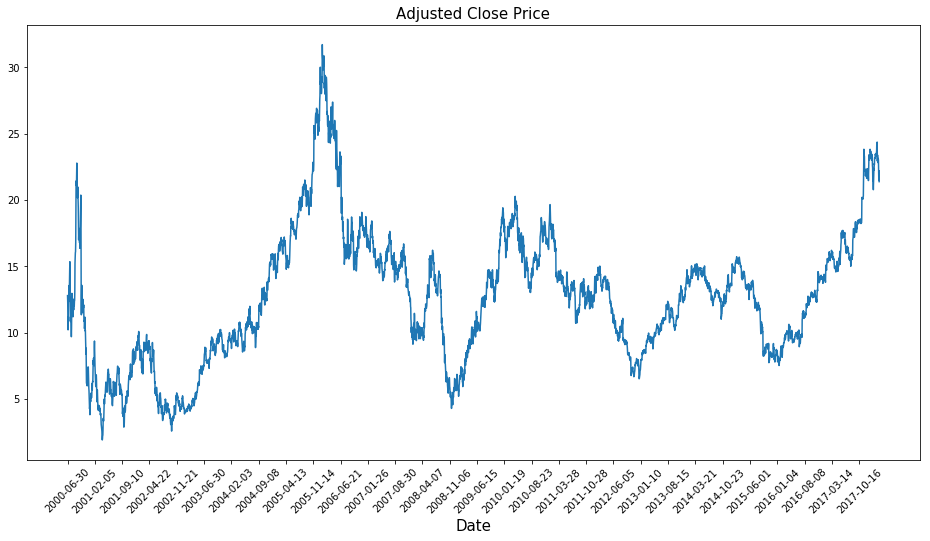

In [6]:
plt.figure(figsize = (16,8))
plt.plot(range(df.shape[0]), df["Adj. Close"])
plt.xticks(range(0,df.shape[0],150), df["Date"][::150], rotation=45)
plt.xlabel("Date", fontsize=15)
plt.title("Adjusted Close Price", fontsize=15)
plt.show()

The data has different ranges and fluctuates a lot with respect to time periods, therefore makes the learning more robust during various testing. This is also the reason why I chose this company.

## Data Normalization

From the plot, we can see that stock values in 2005 are much higher than others and fluctuate a lot in late 2000s. Therefore I will do data normalization to ensure all stock prices are in the same range throughout the whole time period. I split training data and testing data first, and normalize training and testing data both on training data. Noticing that different time periods of data have different value ranges, I introduce windows by splitting full series data and then normalize data on seperate windows respectively.

In [7]:
# Split training, testing data
# first 75% as training, left 25% as testing
n = df.shape[0]
training_size = int(n*3/4)
testing_size = n - training_size
print("training size is {}, testing size is {}".format(training_size, testing_size))

Y = df["Adj. Close"].copy().values
train, test = Y[:training_size].reshape(-1,1), Y[training_size:].reshape(-1,1)

training size is 3345, testing size is 1116


In [8]:
# Split full series data into 3 windows and normalize data on windows
window_size = 1000

scalers = [MinMaxScaler() for i in range(4)]
for i in range(3):
    train[window_size*i:window_size*(i+1),:] = scalers[i].fit_transform(train[window_size*i:window_size*(i+1),:])
train[3000:,:] = scalers[3].fit_transform(train[3000:,:])
test = scalers[3].transform(test)

I also smooth the training data with the exponential moving average here. This is only completed on training data and is for removing the inherent raggedness of stock price data.

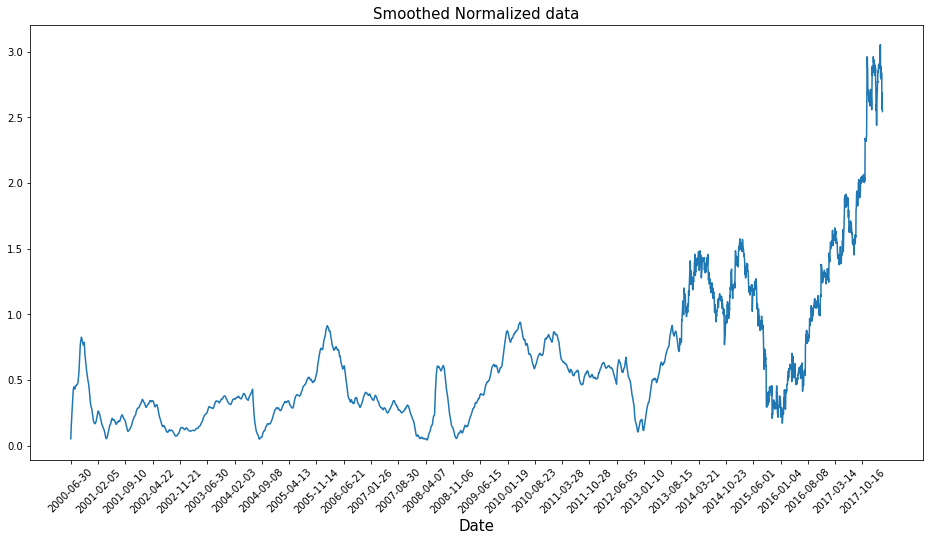

In [9]:
# Smooth the data with the exponential moving average
EMA = 0
gamma = 0.1

for i in range(training_size):
    EMA = gamma*train[i] + (1-gamma)*EMA
    train[i] = EMA

Y_processed = np.r_[train, test]

# Plot processed response variable
plt.figure(figsize = (16,8))
plt.plot(range(df.shape[0]), Y_processed)
plt.xticks(range(0,df.shape[0],150), df["Date"][::150], rotation=45)
plt.xlabel("Date", fontsize=15)
plt.title("Smoothed Normalized data", fontsize=15)
plt.show()

The plot shows that after exponential moving average the training data is much more smooth. The test data should keep untouched. With the processed data, I conduct the following methods to predict next-day stock price: $\mathbf{SVR}, \mathbf{LSTM}, \mathbf{ARIMA}$.

## SVR

SVR (Support vector regression) uses the same principles as SVM for classification, but implements regression by adding a margin of tolerance to the hyperplane because the output is a real number. I try different $\mathsf{lookback}$ here to compare the effect of $\mathsf{timesteps}$. Here $\mathsf{lookback}, \mathsf{timesteps}$ both represent the length of past period of which I am going to use the prices for prediction, or lag observations in other words.

I also use cross validation to search for the best hyper-parameters $\mathbf{C}, \mathbf{gamma}$ for SVR.

In [10]:
# Construct design matrix based on look back step
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data)-look_back):
        dataX.append(data[i:(i+look_back),:])
        dataY.append(data[i+look_back,:])
    
    return np.array(dataX), np.array(dataY)

# transform back to original scales
def inverse_transform(scalers, X, Xtest):
    for i in range(3):
        X[window_size*i:window_size*(i+1),:] = scalers[i].inverse_transform(X[window_size*i:window_size*(i+1),:])
    X[3000:,:] = scalers[3].inverse_transform(X[3000:,:])
    Xtest = scalers[3].inverse_transform(Xtest)
    return X, Xtest

In [11]:
class SVR_set():
    def __init__(self, look_back):
        self.look_back = look_back
    
    def get_data(self):
        # Create design matrix
        trainX, trainY = create_dataset(train, look_back=self.look_back)
        testX, testY = create_dataset(test, look_back=self.look_back)
        trainX = trainX.reshape(trainX.shape[0], trainX.shape[1])
        testX = testX.reshape(testX.shape[0], testX.shape[1])
        
        return trainX, trainY, testX, testY
        
    def tune_param(self):
        trainX, trainY, _, _ = self.get_data()
        
        # Tune parameters using cross validation
        Cs = [0.001, 0.01, 0.1, 1, 10]
        gammas = [0.01, 0.1, 1, 10]
        regressor = GridSearchCV(estimator=SVR(kernel="rbf"), param_grid=dict(C=Cs,gamma=gammas), cv=5)
        regressor.fit(trainX, trainY.reshape(-1))
        best_params = regressor.best_params_
        
        return best_params
    
    def train(self):
        trainX, trainY, testX, testY = self.get_data()
        
        # Create and train the Support Vector Machine (Regression)
        params = self.tune_param()
        mySVR = SVR(kernel="rbf", C=params["C"], gamma=params["gamma"])
        mySVR.fit(trainX, trainY)

        # Predict and return a score
        # Score represents the coefficient of determination R^2 of the prediction.
        trainPredictSVR = mySVR.predict(trainX)
        testPredictSVR = mySVR.predict(testX)
        score = mySVR.score(testX, testY)
        print("SVM R2 confidence: %.2f%%" % score)

        # Transform back to original scores
        trainY, testY = inverse_transform(scalers, trainY, testY)
        trainPredictSVM, testPredictSVM = inverse_transform(scalers, trainPredictSVR.reshape(-1,1), \
                                                            testPredictSVR.reshape(-1,1))

        # model evaluation using mean squared error
        train_score = math.sqrt(mean_squared_error(trainY, trainPredictSVM))
        test_score = math.sqrt(mean_squared_error(testY, testPredictSVM))
        print("MSE for training data is %.2f" % train_score)
        print("MSE for testing data is %.2f" % test_score)

        # model result visualization
        # shift train, test predictions for plotting
        trainPredictSVMPlot, testPredictSVMPlot = np.repeat(np.nan, df.shape[0]), np.repeat(np.nan, df.shape[0])
        trainPredictSVMPlot[self.look_back:training_size] = trainPredictSVM.reshape(-1)
        testPredictSVMPlot[training_size+self.look_back:] = testPredictSVM.reshape(-1)

        plt.figure(figsize=(16,8))
        plt.plot(range(df.shape[0]), df["Adj. Close"])
        plt.xticks(range(0, df.shape[0], 150), df["Date"][::150], rotation=45)
        plt.xlabel("Date", fontsize=15)
        plt.title("SVM Predicted values", fontsize=15)
        plt.plot(range(df.shape[0]), trainPredictSVMPlot)
        plt.plot(range(df.shape[0]), testPredictSVMPlot)
        plt.gca().legend(('True price', 'Train predicted price', 'Test predicted price'))
        plt.show()
        
        return mySVR

look_back = 1


/Users/yingqi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/yingqi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM R2 confidence: -1.23%
MSE for training data is 0.59
MSE for testing data is 5.47


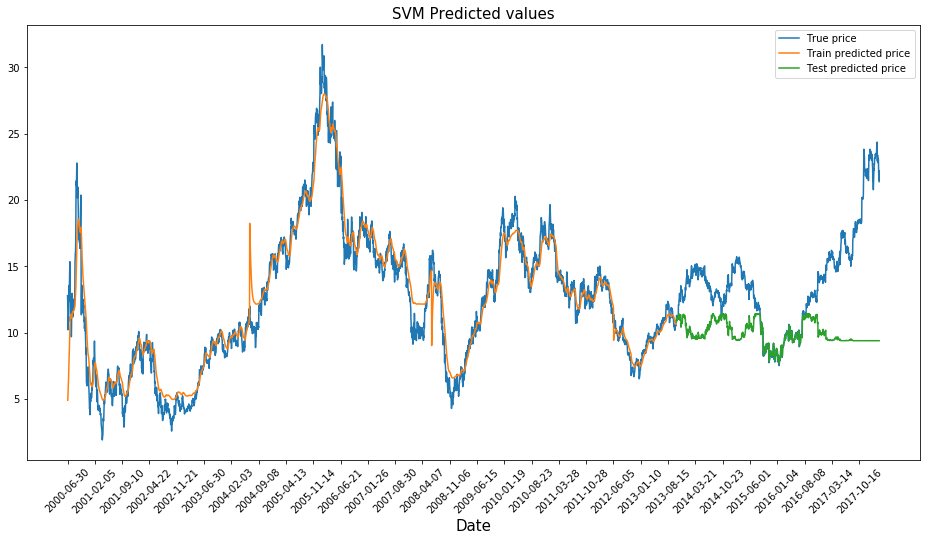

look_back = 10


/Users/yingqi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM R2 confidence: 0.74%
MSE for training data is 0.59
MSE for testing data is 1.86


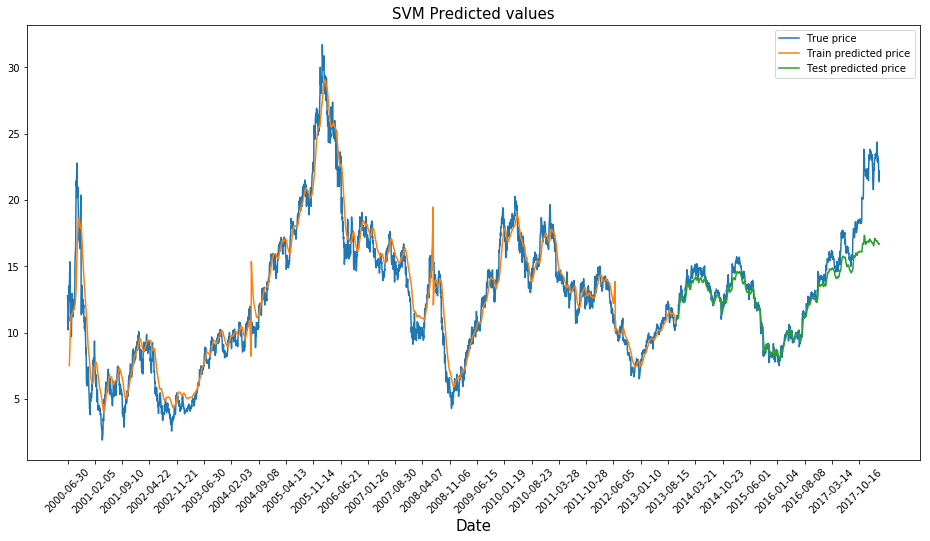

look_back = 30


/Users/yingqi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM R2 confidence: 0.31%
MSE for training data is 0.69
MSE for testing data is 3.06


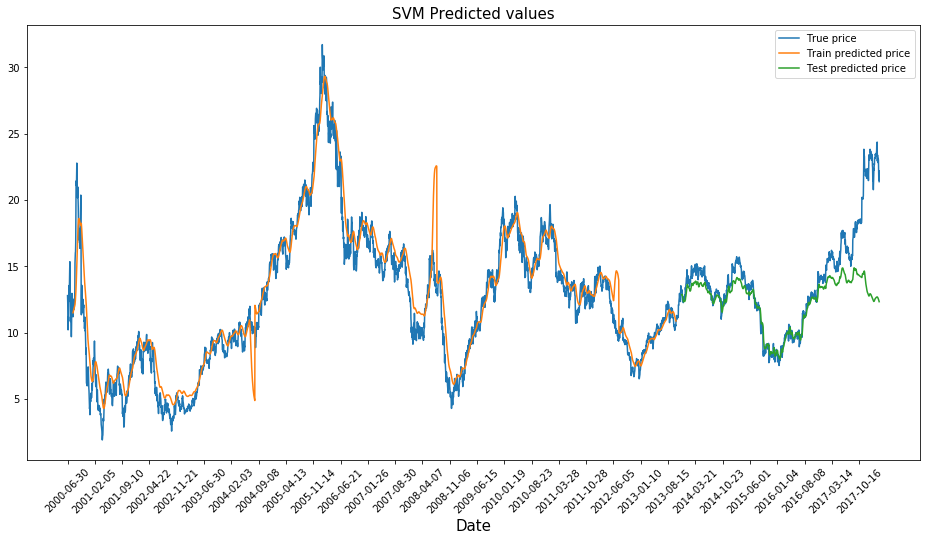

look_back = 60


/Users/yingqi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM R2 confidence: 0.08%
MSE for training data is 0.78
MSE for testing data is 3.59


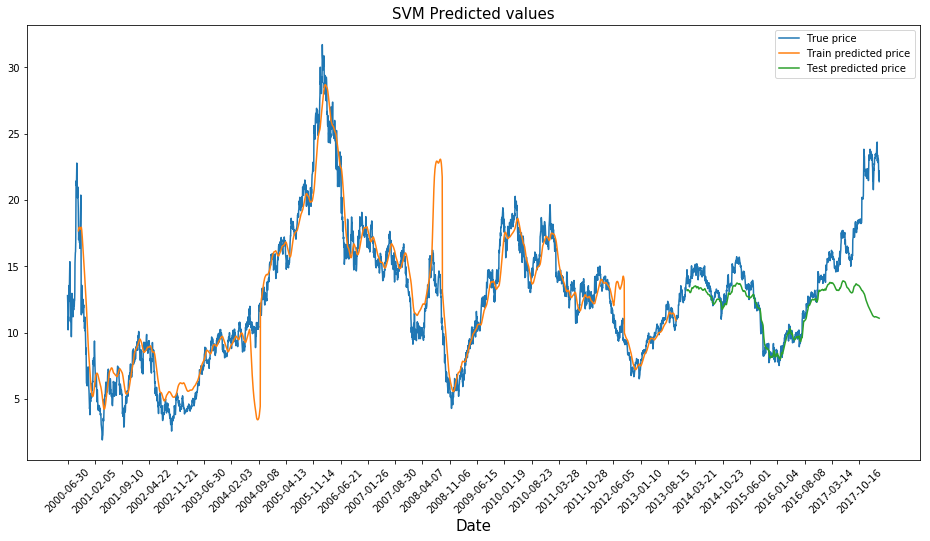

In [12]:
for i in [1, 10, 30, 60]:
    mySVR = SVR_set(i)
    print("look_back = {}".format(i))
    mySVR.train()

Each time I set a different $\mathsf{lookback}$ value, I run a grid search through cross validation for best parameters. I then use the chosen parameters to train a SVR model and plot predicted values. 

Comparing the plots of $\mathsf{lookback}=1, 10, 30, 60$, we can find that using last 1 day's stock price to predict the next day's price doesn't capture future movement at all. If we use last 10/30/60 days' stock prices for prediction, we capture a rough trend in the future but will lose track of the increasing movement after 2016. Instead, the model will predict the price as going down. Besides, using more history price does not improve the model performance, which can be seen from the approximately same prediction trend by tuning features from past 10 days' prices to past 60 days' prices.

In general, SVR model is able to use last 10 days' prices to predict the next day's price and capture the overall movement, except the increasing trend starting from 2016.

## LSTM

$\mathbf{LSTM}$ (long short-term memory) is a recurrent neural network architecture, which possesses feedback connections and allows history information to involve in the learning process. The response variable is the time-series data with respect to time. The input is formulated as $\mathsf{[samples, features, time steps]}$ where $\mathsf{samples}$ is the number of samples we have, $\mathsf{features}$ is number of features we look into, and $\mathsf{time steps}$ is the length of time period in the past we use for prediction. 

In this case, $\mathsf{features}=1$ since I only have stock price as predictor. $\mathsf{timesteps}$ is set as 10 & 60 since I will use stock values from last 10 days and last 2 months to predict the price of next day. Following the rules, I construct the new design matrix $\mathbf{X}$ and $\mathbf{Y}$. The $\mathsf{lookback}$ step is equal to $\mathsf{timesteps}$. If $\mathsf{lookback} = 2$, I will use 1st and 2nd days' prices to predict the 3rd day's stock price.

In [13]:
print("Use last 10 days:")
trainX, trainY = create_dataset(train, look_back=10)
testX, testY = create_dataset(test, look_back=10)

# reshape in [samples, time steps, features]
trainX = np.reshape(trainX, [trainX.shape[0], trainX.shape[1], 1])
testX = np.reshape(testX, [testX.shape[0], testX.shape[1], 1])

print(trainX.shape, trainY.shape, testX.shape, testY.shape)

Use last 10 days:
(3335, 10, 1) (3335, 1) (1106, 10, 1) (1106, 1)


In [14]:
# Create and fit the LSTM network
look_back = 10

model = Sequential()
model.add(LSTM(30, input_shape=(trainX.shape[1], 1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 30s - loss: 0.0016


With the trained model, we can do prediction based on test data. To compare the true price and predicted price, I transform the normalized data back to their original scales.

In [15]:
# Predict 1056 values based on past 10 values
trainPredict, testPredict = model.predict(trainX), model.predict(testX)


trainY, testY = inverse_transform(scalers, trainY, testY)
trainPredict, testPredict = inverse_transform(scalers, trainPredict, testPredict)

In [16]:
# model evaluation using mean squared error
train_score = math.sqrt(mean_squared_error(trainY, trainPredict))
test_score = math.sqrt(mean_squared_error(testY, testPredict))
print("MSE for training data is %.2f" % train_score)
print("MSE for testing data is %.2f" % test_score)

MSE for training data is 0.29
MSE for testing data is 0.93


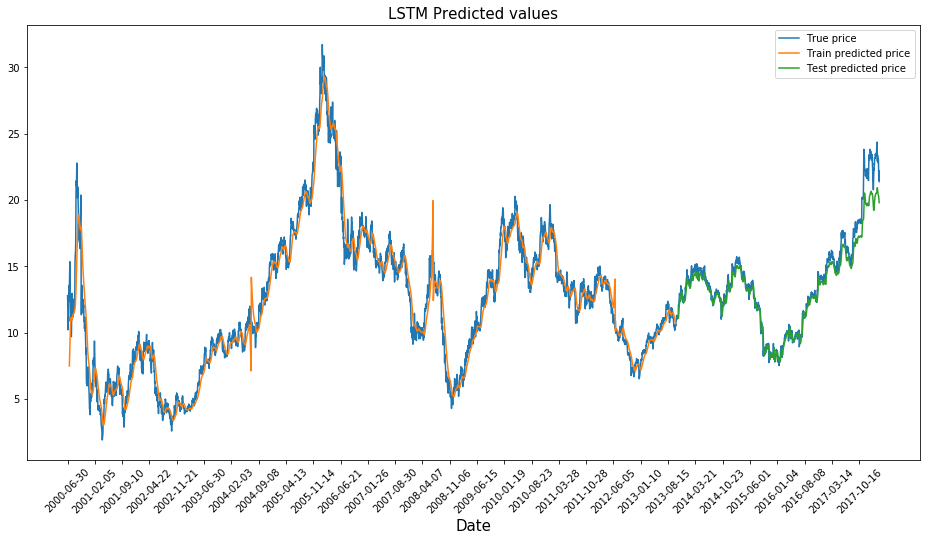

In [17]:
# model result visualization
# shift train, test predictions for plotting
trainPredictPlot, testPredictPlot = np.repeat(np.nan, df.shape[0]), np.repeat(np.nan, df.shape[0])
trainPredictPlot[look_back:training_size] = trainPredict.reshape(-1)
testPredictPlot[training_size+look_back:] = testPredict.reshape(-1)

plt.figure(figsize=(16,8))
plt.plot(range(df.shape[0]), df["Adj. Close"])
plt.xticks(range(0, df.shape[0], 150), df["Date"][::150], rotation=45)
plt.xlabel("Date", fontsize=15)
plt.title("LSTM Predicted values", fontsize=15)
plt.plot(range(df.shape[0]), trainPredictPlot)
plt.plot(range(df.shape[0]), testPredictPlot)
plt.gca().legend(('True price', 'Train predicted price', 'Test predicted price'))
plt.show()

Similarly, I construct a LSTM model using last 2 months' stock prices for prediction.

Use last 60 days:
Epoch 1/1
 - 136s - loss: 0.0014
MSE for training data is 0.29
MSE for testing data is 0.43


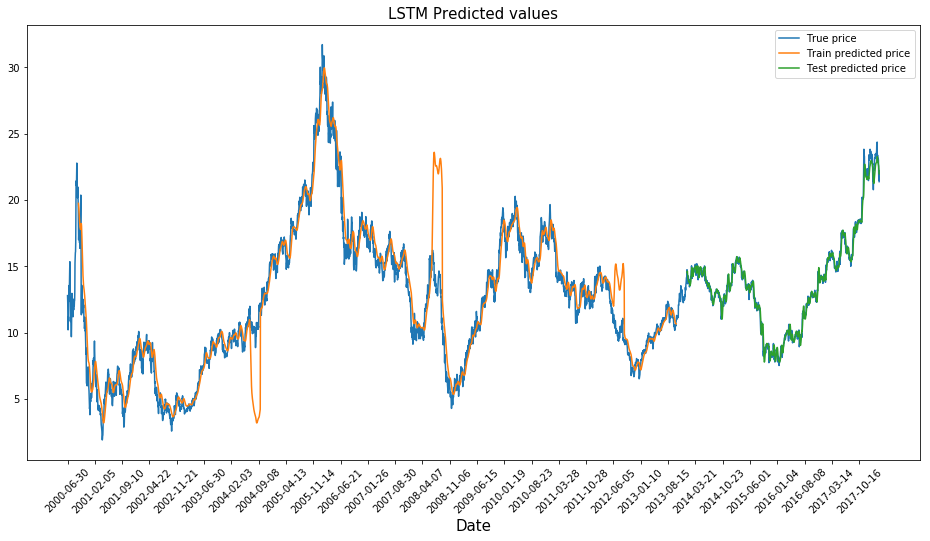

In [18]:
print("Use last 60 days:")
trainX, trainY = create_dataset(train, look_back=60)
testX, testY = create_dataset(test, look_back=60)
# reshape in [samples, time steps, features]
trainX = np.reshape(trainX, [trainX.shape[0], trainX.shape[1], 1])
testX = np.reshape(testX, [testX.shape[0], testX.shape[1], 1])

# Create and fit the LSTM network
look_back = 60
model = Sequential()
model.add(LSTM(30, input_shape=(trainX.shape[1], 1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)

# Predict 1056 values based on past 60 values
trainPredict, testPredict = model.predict(trainX), model.predict(testX)

# transform back to original scales
trainY, testY = inverse_transform(scalers, trainY, testY)
trainPredict, testPredict = inverse_transform(scalers, trainPredict, testPredict)

# model evaluation using mean squared error
train_score = math.sqrt(mean_squared_error(trainY, trainPredict))
test_score = math.sqrt(mean_squared_error(testY, testPredict))
print("MSE for training data is %.2f" % train_score)
print("MSE for testing data is %.2f" % test_score)

# model result visualization
# shift train, test predictions for plotting
trainPredictPlot, testPredictPlot = np.repeat(np.nan, df.shape[0]), np.repeat(np.nan, df.shape[0])
trainPredictPlot[look_back:training_size] = trainPredict.reshape(-1)
testPredictPlot[training_size+look_back:] = testPredict.reshape(-1)

plt.figure(figsize=(16,8))
plt.plot(range(df.shape[0]), df["Adj. Close"])
plt.xticks(range(0, df.shape[0], 150), df["Date"][::150], rotation=45)
plt.xlabel("Date", fontsize=15)
plt.title("LSTM Predicted values", fontsize=15)
plt.plot(range(df.shape[0]), trainPredictPlot)
plt.plot(range(df.shape[0]), testPredictPlot)
plt.gca().legend(('True price', 'Train predicted price', 'Test predicted price'))
plt.show()

I plot the stock data, predicted training data, and predicted testing data as above. We can see that the LSTM model fits well with the data and captures the trend fully in the series. The 3 abnormal peaks or valleys in training data are due to different scaling ranges in split windows, and are not due to prediction error. Therefore, we can conclude that LSTM performs well in this situation even with a relatively simple network structure (2 layers). 

Also, using last 2 months' prices for prediction only reduces error slightly compared with using last 10 days' prices, and the moving trend is fully represented in predicted values in both scenarios.

Comparing the SVR models with the LSTM model, we can conclude that LSTM is more powerful in prediction.

## ARIMA

$\mathbf{ARIMA}$ (AutoRegressive Integrated Moving Average) caters to a suite of standard structures in time series data, and takes into account past values, past forecast errors, and differencing of raw observations for explanation. I implement ARIMA here and complete differencing before modeling to remove the effect of trend and seasonality, and thus satisfy stationarity.

I also plot the autocorrelation for a large number of lags in the time series. In the plot there is a positive correlation with the first 400 lags and the correlation with the first 100 lags are significant. For consistency, I will use $\mathsf{lag}=10$ as a starting point of the AR parameter here.

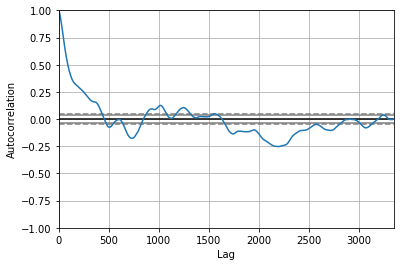

In [19]:
autocorrelation_plot(train)
plt.show() 

Then I fit an ARIMA(10,1,0) model based on our training data. This sets the lag value to 10 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

In [20]:
myARIMA = ARIMA(train, order=(10,1,0))
myARIMA_fit = myARIMA.fit(disp=0)
# Order of difference = 1, therefore predicts all stock prices in the dataset except the first one
testPredictARIMA = myARIMA_fit.predict(start=1, end=df.shape[0]-1, typ="levels").reshape(-1,1)
testPredictARIMA = np.r_[np.array(0).reshape(-1,1), testPredictARIMA]

# Transform back to original scores
for i in range(3):
    testPredictARIMA[window_size*i:window_size*(i+1)] = scalers[i].\
        inverse_transform(testPredictARIMA[window_size*i:window_size*(i+1)])
testPredictARIMA[3000:] = scalers[3].inverse_transform(testPredictARIMA[3000:])
testPredictARIMA[0,:] = np.nan

# model evaluation using mean squared error
train_score = math.sqrt(mean_squared_error(train[1:], testPredictARIMA[1:training_size]))
test_score = math.sqrt(mean_squared_error(test, testPredictARIMA[training_size:]))
print("MSE for training data is %.2f" % train_score)
print("MSE for testing data is %.2f" % test_score)

MSE for training data is 12.89
MSE for testing data is 10.78


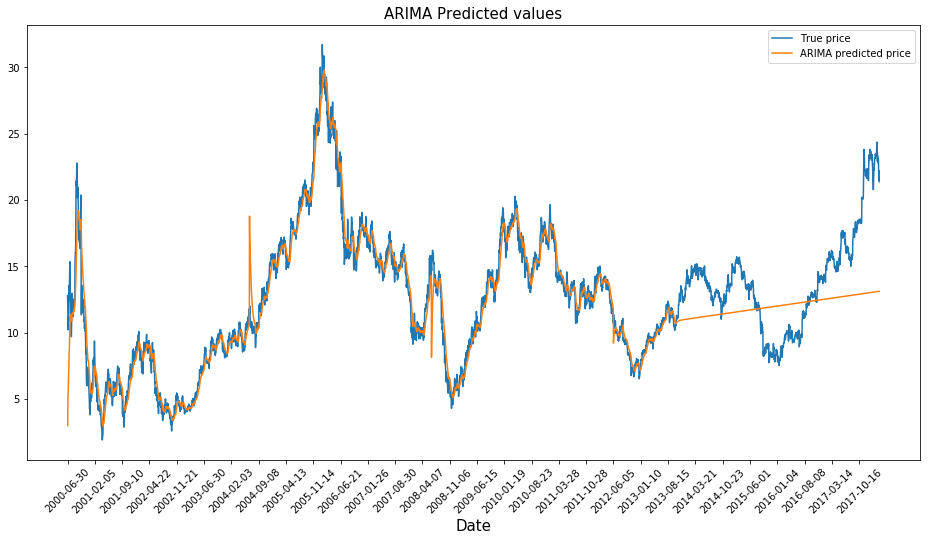

In [21]:
plt.figure(figsize=(16,8))
plt.plot(range(df.shape[0]), df["Adj. Close"])
plt.xticks(range(0, df.shape[0], 150), df["Date"][::150], rotation=45)
plt.xlabel("Date", fontsize=15)
plt.title("ARIMA Predicted values", fontsize=15)
plt.plot(range(df.shape[0]), testPredictARIMA)
plt.gca().legend(('True price', 'ARIMA predicted price'))
plt.show()

From the plot, we can see that the ARIMA model captures an increasing trend in the testing data. It's correct but the model fails to represent the raises and drops with respect to seasons. 

This is a simple implementation of ARIMA method, and further study can be done in tuning the parameters which leads to a better model. However, ARIMA model does not perform as well as LSTM and SVR in this case.